In [35]:
print(2)

2


In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
import random; random.seed(42)
!pip install -q evaluate torchinfo bitsandbytes peft

In [38]:
import numpy as np
import pandas as pd
from datasets import Dataset
import evaluate
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import TrainingArguments, Trainer
from torchinfo import summary
import torch
from transformers import BertTokenizer, BertForSequenceClassification, BitsAndBytesConfig
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random

In [39]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [40]:
random.seed(42)

## Load Datasets, Tokenizer, and Model

In [41]:
train_df = pd.read_csv('/content/drive/MyDrive/266/MLMA_Toxicity_Detection_Deep_Learning/Data/combined_train.csv')
val_df = pd.read_csv('/content/drive/MyDrive/266/MLMA_Toxicity_Detection_Deep_Learning/Data/combined_val.csv')
test_df = pd.read_csv('/content/drive/MyDrive/266/MLMA_Toxicity_Detection_Deep_Learning/Data/combined_test.csv')

train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

## Multi-Label Prediction

In [42]:
example = train_dataset[0]
example

{'text_cleaned': 'يلعن شرفك يا حكم!!!',
 'language': 'arabic',
 'directness_label': 2,
 'target_label': 2,
 'group_label': 12,
 'hatespeech': 0,
 'hatespeech.1': 0,
 'directness_label.1': 2,
 'target_label.1': 2,
 'group_label.1': 12,
 'sentiment_anger': 0,
 'sentiment_confusion': 0,
 'sentiment_disgust': 0,
 'sentiment_fear': 0,
 'sentiment_indifference': 0,
 'sentiment_normal': 1,
 'sentiment_sadness': 0,
 'sentiment_shock': 0,
 'language_encoded': 2}

In [43]:
from datasets import DatasetDict

dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text_cleaned', 'language', 'directness_label', 'target_label', 'group_label', 'hatespeech', 'hatespeech.1', 'directness_label.1', 'target_label.1', 'group_label.1', 'sentiment_anger', 'sentiment_confusion', 'sentiment_disgust', 'sentiment_fear', 'sentiment_indifference', 'sentiment_normal', 'sentiment_sadness', 'sentiment_shock', 'language_encoded'],
        num_rows: 30702
    })
    validation: Dataset({
        features: ['text_cleaned', 'language', 'directness_label', 'target_label', 'group_label', 'hatespeech', 'hatespeech.1', 'directness_label.1', 'target_label.1', 'group_label.1', 'sentiment_anger', 'sentiment_confusion', 'sentiment_disgust', 'sentiment_fear', 'sentiment_indifference', 'sentiment_normal', 'sentiment_sadness', 'sentiment_shock', 'language_encoded'],
        num_rows: 3901
    })
    test: Dataset({
        features: ['text_cleaned', 'language', 'directness_label', 'target_label', 'group_label', 'hatespeech', 

In [44]:
example = dataset['train'][13000]
example

{'text_cleaned': "c'est un gros mongol quand même",
 'language': 'french',
 'directness_label': 0,
 'target_label': 3,
 'group_label': 8,
 'hatespeech': 1,
 'hatespeech.1': 1,
 'directness_label.1': 0,
 'target_label.1': 3,
 'group_label.1': 8,
 'sentiment_anger': 0,
 'sentiment_confusion': 0,
 'sentiment_disgust': 0,
 'sentiment_fear': 0,
 'sentiment_indifference': 0,
 'sentiment_normal': 0,
 'sentiment_sadness': 0,
 'sentiment_shock': 1,
 'language_encoded': 1}

In [45]:
# Original binary labels
binary_label_columns = [
    'hatespeech',
    'sentiment_indifference',
    'sentiment_disgust',
    'sentiment_sadness',
    'sentiment_anger',
    'sentiment_shock',
    'sentiment_normal',
    'sentiment_confusion',
    'sentiment_fear'
]

# Get unique values for multiclass labels to determine the range for one-hot encoding
directness_values = sorted(train_df['directness_label'].unique().tolist())
target_values = sorted(train_df['target_label'].unique().tolist())
group_values = sorted(train_df['group_label'].unique().tolist())

# Create names for one-hot encoded binary labels
directness_binary_labels = [f'directness_label_{val}' for val in directness_values]
target_binary_labels = [f'target_label_{val}' for val in target_values]
group_binary_labels = [f'group_label_{val}' for val in group_values]

# Combine all binary label names
all_binary_labels = binary_label_columns + directness_binary_labels + target_binary_labels + group_binary_labels

# Update id2label and label2id
id2label = {idx:label for idx, label in enumerate(all_binary_labels)}
label2id = {label:idx for idx, label in enumerate(all_binary_labels)}

# The total number of binary labels
num_binary_labels = len(all_binary_labels)

print(f"Total number of binary labels: {num_binary_labels}")
print(f"All binary labels: {all_binary_labels}")

Total number of binary labels: 36
All binary labels: ['hatespeech', 'sentiment_indifference', 'sentiment_disgust', 'sentiment_sadness', 'sentiment_anger', 'sentiment_shock', 'sentiment_normal', 'sentiment_confusion', 'sentiment_fear', 'directness_label_0', 'directness_label_1', 'directness_label_2', 'target_label_0', 'target_label_1', 'target_label_2', 'target_label_3', 'target_label_4', 'target_label_5', 'target_label_6', 'group_label_0', 'group_label_1', 'group_label_2', 'group_label_3', 'group_label_4', 'group_label_5', 'group_label_6', 'group_label_7', 'group_label_8', 'group_label_9', 'group_label_10', 'group_label_11', 'group_label_12', 'group_label_13', 'group_label_14', 'group_label_15', 'group_label_16']


In [46]:
!rm -r "google/rembert" # if the next cell gives error "not a string", run this cell

In [47]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained('google/rembert')
model = AutoModelForSequenceClassification.from_pretrained('google/rembert',
                                                           problem_type="multi_label_classification",
                                                           num_labels=len(all_binary_labels),
                                                           id2label=id2label,
                                                           label2id=label2id)

Some weights of RemBertForSequenceClassification were not initialized from the model checkpoint at google/rembert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [48]:
import torch
import numpy as np

# Get unique values for multiclass labels to determine the range for one-hot encoding
directness_values = sorted(train_df['directness_label'].unique().tolist())
target_values = sorted(train_df['target_label'].unique().tolist())
group_values = sorted(train_df['group_label'].unique().tolist())

def preprocess_multioutput_data(examples):
  # take a batch of texts
  text = [str(x) for x in examples["text_cleaned"]]
  # encode them, returning PyTorch tensors directly
  encoding = tokenizer(text, padding="max_length", truncation=True, max_length=150, return_tensors="pt")

  # Create list of binary label tensors
  binary_labels_list = [
      torch.tensor(examples["hatespeech"]),
      torch.tensor(examples["sentiment_anger"]),
      torch.tensor(examples["sentiment_confusion"]),
      torch.tensor(examples["sentiment_disgust"]),
      torch.tensor(examples["sentiment_fear"]),
      torch.tensor(examples["sentiment_indifference"]),
      torch.tensor(examples["sentiment_normal"]),
      torch.tensor(examples["sentiment_sadness"]),
      torch.tensor(examples["sentiment_shock"])
  ]

  # Perform one-hot encoding for multiclass labels and add to the list
  for i, val in enumerate(directness_values):
      binary_labels_list.append(torch.tensor([1.0 if label == val else 0.0 for label in examples["directness_label"]]))

  for i, val in enumerate(target_values):
      binary_labels_list.append(torch.tensor([1.0 if label == val else 0.0 for label in examples["target_label"]]))

  for i, val in enumerate(group_values):
      binary_labels_list.append(torch.tensor([1.0 if label == val else 0.0 for label in examples["group_label"]]))


  # Stack all binary label tensors along dimension 1
  labels_tensor = torch.stack(binary_labels_list, dim=1).float()

  # Add the stacked labels tensor to the encoding dictionary
  encoding['labels'] = labels_tensor

  return encoding

In [49]:


# Apply the preprocessing function with batching
encoded_dataset = dataset.map(preprocess_multioutput_data, batched=True, remove_columns=dataset['train'].column_names)


Map:   0%|          | 0/30702 [00:00<?, ? examples/s]

Map:   0%|          | 0/3901 [00:00<?, ? examples/s]

Map:   0%|          | 0/3901 [00:00<?, ? examples/s]

In [50]:
example = encoded_dataset['train'][13000]
print(example.keys())

print(tokenizer.decode(example['input_ids']))

print(example)

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
[CLS] c'est un gros mongol quand même[SEP][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]
{'input_ids': [312, 897, 584, 1121, 621, 33105, 65473, 14488, 4573, 313, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [51]:
for name, param in model.named_parameters():
    print(name)

rembert.embeddings.word_embeddings.weight
rembert.embeddings.position_embeddings.weight
rembert.embeddings.token_type_embeddings.weight
rembert.embeddings.LayerNorm.weight
rembert.embeddings.LayerNorm.bias
rembert.encoder.embedding_hidden_mapping_in.weight
rembert.encoder.embedding_hidden_mapping_in.bias
rembert.encoder.layer.0.attention.self.query.weight
rembert.encoder.layer.0.attention.self.query.bias
rembert.encoder.layer.0.attention.self.key.weight
rembert.encoder.layer.0.attention.self.key.bias
rembert.encoder.layer.0.attention.self.value.weight
rembert.encoder.layer.0.attention.self.value.bias
rembert.encoder.layer.0.attention.output.dense.weight
rembert.encoder.layer.0.attention.output.dense.bias
rembert.encoder.layer.0.attention.output.LayerNorm.weight
rembert.encoder.layer.0.attention.output.LayerNorm.bias
rembert.encoder.layer.0.intermediate.dense.weight
rembert.encoder.layer.0.intermediate.dense.bias
rembert.encoder.layer.0.output.dense.weight
rembert.encoder.layer.0.output

In [52]:
# Freeze all of the pre-trained BERT layers to make the fine tuning go much faster.
# Then later we'll try unfreezing some or all layers and see what works better.
# We need to keep the final classification layer unfrozen no matter what,
# because that's a new layer that hasn't been trained at all yet, and needs to be trained for our task.


for name, param in model.named_parameters():
    param.requires_grad = False

In [53]:
summary(model)

Layer (type:depth-idx)                                       Param #
RemBertForSequenceClassification                             --
├─RemBertModel: 1-1                                          --
│    └─RemBertEmbeddings: 2-1                                --
│    │    └─Embedding: 3-1                                   (64,076,800)
│    │    └─Embedding: 3-2                                   (131,072)
│    │    └─Embedding: 3-3                                   (512)
│    │    └─LayerNorm: 3-4                                   (512)
│    │    └─Dropout: 3-5                                     --
│    └─RemBertEncoder: 2-2                                   --
│    │    └─Linear: 3-6                                      (296,064)
│    │    └─ModuleList: 3-7                                  (510,087,168)
│    └─RemBertPooler: 2-3                                    --
│    │    └─Linear: 3-8                                      (1,328,256)
│    │    └─Tanh: 3-9                            

In [54]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score, balanced_accuracy_score
from transformers import EvalPrediction
import torch
import numpy as np # Import numpy

def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels.astype(int) # Ensure labels are integers
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_true.flatten(), y_pred.flatten())
    precision = precision_score(y_true=y_true, y_pred=y_pred, average='micro', zero_division=0)
    recall = recall_score(y_true=y_true, y_pred=y_pred, average='micro', zero_division=0)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy,
               'balanced_accuracy': balanced_accuracy,
               'precision': precision,
               'recall': recall}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions,
            tuple) else p.predictions

    # Ensure labels are a 2D numpy array of integers
    labels_np = np.array(p.label_ids)
    if labels_np.ndim == 1:
        # This might happen if the batch size is 1, reshape to (1, num_labels)
        labels_np = labels_np.reshape(1, -1)
    elif labels_np.ndim > 2:
        # Handle cases where labels might have extra dimensions unexpectedly
        # This might require more specific reshaping based on the actual structure
        # For now, let's assume the expected shape is (batch_size, num_labels)
        # and try to flatten and reshape if necessary.
        # A safer approach might be to raise an error or log a warning here.
        print(f"Warning: Unexpected label dimension: {labels_np.ndim}")
        # Attempt to flatten and reshape - adjust if your data structure is different
        labels_np = labels_np.reshape(labels_np.shape[0], -1)


    result = multi_label_metrics(
        predictions=preds,
        labels=labels_np)
    return result

In [55]:
#forward pass
# # Check the type of the data after setting the format
# print(f"Type of input_ids[0]: {encoded_dataset['train']['input_ids'][0].type()}")
# print(f"Type of labels[0]: {encoded_dataset['train'][0]['hatespeech_labels'].type()}")

# Also print a sample example to see the structure
print("Sample example after setting format:")
print(encoded_dataset['train'][0])

# Manually get a sample and prepare input for the model
sample = encoded_dataset['train'][0]

# Convert lists to PyTorch tensors before unsqueezing
input_ids_tensor = torch.tensor(sample['input_ids']).unsqueeze(0)
attention_mask_tensor = torch.tensor(sample['attention_mask']).unsqueeze(0)
labels_tensor = torch.tensor(sample['labels']).unsqueeze(0)

# Move tensors to the same device as the model
device = model.device
input_ids_tensor = input_ids_tensor.to(device)
attention_mask_tensor = attention_mask_tensor.to(device)
labels_tensor = labels_tensor.to(device)


outputs = model(input_ids=input_ids_tensor, attention_mask=attention_mask_tensor, labels=labels_tensor)
outputs

Sample example after setting format:
{'input_ids': [312, 573, 8671, 114741, 573, 81901, 2262, 14900, 573, 43540, 3902, 313, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RemBertSelfAttention.forward`.
  return forward_call(*args, **kwargs)


SequenceClassifierOutput(loss=tensor(0.7535), logits=tensor([[-0.2799, -0.3151,  0.8649,  0.3950,  0.2614, -0.4922, -0.3236, -0.2243,
         -0.2121,  0.2648, -0.3675, -0.0303, -0.4708, -0.2490, -0.4608, -0.3320,
          0.4749, -0.1872,  0.3276,  0.2692,  0.3096,  0.0181,  0.3458,  0.0630,
          0.3048, -0.2772, -0.0727,  0.2668,  0.3362,  0.2457,  0.1611, -0.1097,
          0.6262, -0.3119, -0.0015,  0.5973]]), hidden_states=None, attentions=None)

# 1. Increase batch size and unfreeze layer 31

In [56]:
from transformers import TrainingArguments, Trainer
from transformers import EarlyStoppingCallback

batch_size = 8 # 128 # nadaa said to lower batch size
metric_name = "eval_f1"

args = TrainingArguments(
    f"google/rembert",
    eval_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=4e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_steps=100, # Set logging steps to a smaller value
    greater_is_better=True, # F1 score is better when higher
    report_to='none' # Disable reporting to wandb for this example
)

# Add EarlyStoppingCallback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3, # Number of evaluation epochs to wait before stopping
    early_stopping_threshold=0.0 # Minimum improvement to consider as progress
)

In [57]:
# Unfreeze classifier, pooler, and layer 31

for name, param in model.named_parameters():
    if name.split(".")[0] == "rembert" and "encoder.layer.31" in name:
        param.requires_grad = True
    elif name in ["pre_classifier.weight", "pre_classifier.bias", "classifier.weight", "classifier.bias"]:
        param.requires_grad = True
    else:
        param.requires_grad = False

summary(model)

Layer (type:depth-idx)                                       Param #
RemBertForSequenceClassification                             --
├─RemBertModel: 1-1                                          --
│    └─RemBertEmbeddings: 2-1                                --
│    │    └─Embedding: 3-1                                   (64,076,800)
│    │    └─Embedding: 3-2                                   (131,072)
│    │    └─Embedding: 3-3                                   (512)
│    │    └─LayerNorm: 3-4                                   (512)
│    │    └─Dropout: 3-5                                     --
│    └─RemBertEncoder: 2-2                                   --
│    │    └─Linear: 3-6                                      (296,064)
│    │    └─ModuleList: 3-7                                  510,087,168
│    └─RemBertPooler: 2-3                                    --
│    │    └─Linear: 3-8                                      (1,328,256)
│    │    └─Tanh: 3-9                              

In [58]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/tmp/ipython-input-3132099784.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [59]:
print(encoded_dataset['train']['labels'][13000])

[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [60]:
trainer.train()wd

SyntaxError: invalid syntax (ipython-input-1036639294.py, line 1)

In [ ]:
trainer.evaluate()

# 2. Unfreeze layer 30

In [ ]:
# Unfreeze classifier, pooler, and layer 4 and 5

for name, param in model.named_parameters():
    if name.split(".")[0] == "rembert" and "encoder.layer.31" in name:
        param.requires_grad = True
    elif name.split(".")[0] == "rembert" and "encoder.layer.30" in name:
        param.requires_grad = True
    elif name in ["pre_classifier.weight", "pre_classifier.bias", "classifier.weight", "classifier.bias"]:
        param.requires_grad = True
    else:
        param.requires_grad = False

summary(model)

In [ ]:
args = TrainingArguments(
    f'google/rembert',
    eval_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=4e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_steps=100, # Set logging steps to a smaller value
    greater_is_better=True, # F1 score is better when higher
    report_to='none' # Disable reporting to wandb for this example
)

trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

In [ ]:
trainer.evaluate()

# 3. Increase Learning Rate

In [ ]:
args = TrainingArguments(
    f'google/rembert',
    eval_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=6e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_steps=100, # Set logging steps to a smaller value
    greater_is_better=True, # F1 score is better when higher
    report_to='none' # Disable reporting to wandb for this example
)

trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

In [ ]:
trainer.evaluate()

# 4. Unfreeze layer 29

In [61]:
# Unfreeze classifier, pooler, and layer 3, 4, and 5

for name, param in model.named_parameters():
    if name.split(".")[0] == "rembert" and "encoder.layer.31" in name:
        param.requires_grad = True
    elif name.split(".")[0] == "rembert" and "encoder.layer.30" in name:
        param.requires_grad = True
    elif name.split(".")[0] == "rembert" and "encoder.layer.29" in name:
        param.requires_grad = True
    elif name in ["pre_classifier.weight", "pre_classifier.bias", "classifier.weight", "classifier.bias"]:
        param.requires_grad = True
    else:
        param.requires_grad = False

summary(model)

Layer (type:depth-idx)                                       Param #
RemBertForSequenceClassification                             --
├─RemBertModel: 1-1                                          --
│    └─RemBertEmbeddings: 2-1                                --
│    │    └─Embedding: 3-1                                   (64,076,800)
│    │    └─Embedding: 3-2                                   (131,072)
│    │    └─Embedding: 3-3                                   (512)
│    │    └─LayerNorm: 3-4                                   (512)
│    │    └─Dropout: 3-5                                     --
│    └─RemBertEncoder: 2-2                                   --
│    │    └─Linear: 3-6                                      (296,064)
│    │    └─ModuleList: 3-7                                  510,087,168
│    └─RemBertPooler: 2-3                                    --
│    │    └─Linear: 3-8                                      (1,328,256)
│    │    └─Tanh: 3-9                              

In [62]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

/tmp/ipython-input-3525685056.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RemBertSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy,Balanced Accuracy,Precision,Recall
1,0.150300,0.154108,0.725676,0.808555,0.477314,0.808555,0.843020,0.637008
2,0.144000,0.147891,0.744881,0.826735,0.477057,0.826735,0.827728,0.677109
3,0.128000,0.153667,0.749579,0.834205,0.485517,0.834205,0.813185,0.695202
4,0.115100,0.149626,0.755280,0.836527,0.481671,0.836527,0.822283,0.698374
5,0.111700,0.154679,0.754244,0.837407,0.482184,0.837407,0.815703,0.701398


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RemBertSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RemBertSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RemBertSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RemBertSelfAttention.forward`.
  return forward_call(*args, **kwargs)


TrainOutput(global_step=19190, training_loss=0.13565390831856383, metrics={'train_runtime': 4888.5067, 'train_samples_per_second': 31.402, 'train_steps_per_second': 3.926, 'total_flos': 7.0703352911772e+16, 'train_loss': 0.13565390831856383, 'epoch': 5.0})

In [63]:
trainer.evaluate()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RemBertSelfAttention.forward`.
  return forward_call(*args, **kwargs)


{'eval_loss': 0.14962564408779144,
 'eval_f1': 0.7552803688217005,
 'eval_roc_auc': 0.8365272131623359,
 'eval_accuracy': 0.4816713663163291,
 'eval_balanced_accuracy': 0.8365272131623358,
 'eval_precision': 0.8222831796428155,
 'eval_recall': 0.6983741449390304,
 'eval_runtime': 90.9751,
 'eval_samples_per_second': 42.88,
 'eval_steps_per_second': 5.364,
 'epoch': 5.0}

In [64]:
# learning rate back down
args = TrainingArguments(
    f'rembert-multilabel_best',
    eval_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=4e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_steps=100, # Set logging steps to a smaller value
    greater_is_better=True, # F1 score is better when higher
    report_to='none' # Disable reporting to wandb for this example
)
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

/tmp/ipython-input-2120202975.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RemBertSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy,Balanced Accuracy,Precision,Recall
1,0.115900,0.156950,0.734963,0.819424,0.469880,0.819424,0.825477,0.662338
2,0.106800,0.160608,0.751184,0.841901,0.478852,0.841901,0.790462,0.715624
3,0.082000,0.170409,0.746760,0.838835,0.478595,0.838835,0.787872,0.709725
4,0.062600,0.183556,0.748213,0.841355,0.482184,0.841355,0.783614,0.715872
5,0.048100,0.197298,0.744331,0.839968,0.484491,0.839968,0.776957,0.714335


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RemBertSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RemBertSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RemBertSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RemBertSelfAttention.forward`.
  return forward_call(*args, **kwargs)


TrainOutput(global_step=19190, training_loss=0.08571712924764453, metrics={'train_runtime': 4911.0051, 'train_samples_per_second': 31.258, 'train_steps_per_second': 3.908, 'total_flos': 7.0703352911772e+16, 'train_loss': 0.08571712924764453, 'epoch': 5.0})

In [65]:
trainer.save_model("rembert-multilabel_best")
tokenizer.save_pretrained("rembert-multilabel_best")

('rembert-multilabel_best/tokenizer_config.json',
 'rembert-multilabel_best/special_tokens_map.json',
 'rembert-multilabel_best/sentencepiece.model',
 'rembert-multilabel_best/added_tokens.json',
 'rembert-multilabel_best/tokenizer.json')

In [66]:
trainer.evaluate()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RemBertSelfAttention.forward`.
  return forward_call(*args, **kwargs)


{'eval_loss': 0.16060832142829895,
 'eval_f1': 0.7511837244393569,
 'eval_roc_auc': 0.8419009411817607,
 'eval_accuracy': 0.4788515765188413,
 'eval_balanced_accuracy': 0.8419009411817607,
 'eval_precision': 0.7904621112571178,
 'eval_recall': 0.7156240705859026,
 'eval_runtime': 91.8852,
 'eval_samples_per_second': 42.455,
 'eval_steps_per_second': 5.311,
 'epoch': 5.0}

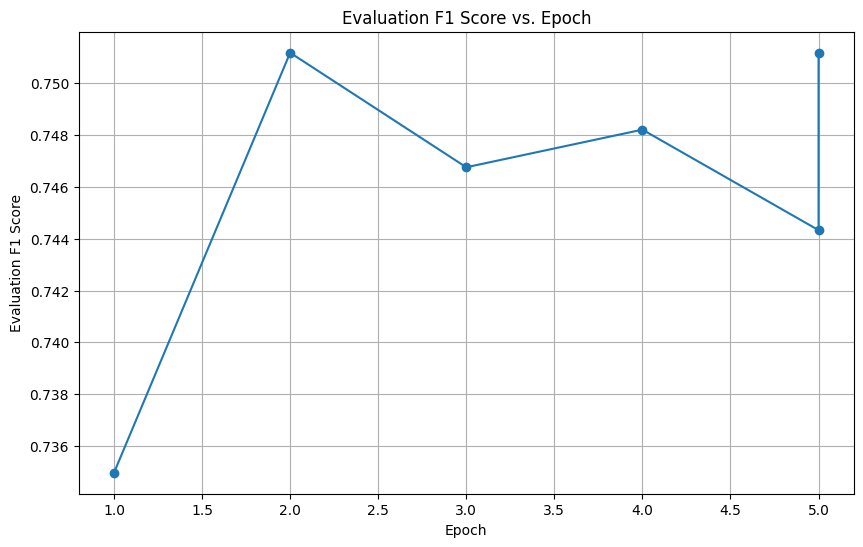

In [67]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract the log history from the trainer state
log_history = trainer.state.log_history

# Filter for evaluation logs that contain 'eval_f1' and 'epoch'
eval_logs = [log for log in log_history if 'eval_f1' in log and 'epoch' in log]

# Create a pandas DataFrame from the filtered logs
eval_df = pd.DataFrame(eval_logs)

# Plot the F1 score vs epoch
plt.figure(figsize=(10, 6))
plt.plot(eval_df['epoch'], eval_df['eval_f1'], marker='o')
plt.xlabel('Epoch')
plt.ylabel('Evaluation F1 Score')
plt.title('Evaluation F1 Score vs. Epoch')
plt.grid(True)
plt.show()